<a href="https://colab.research.google.com/github/OD1992/Python-programs/blob/main/Change_point_belgium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
#!pip install pymc3
import pymc3 as pm
import theano.tensor as tt
import theano
import datetime
import time


confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
deaths_url =  'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(deaths_url, sep=',')
path_to_save = ''
confirmed_cases
data_end   = '5/15/20' #Take the data until yesterday
data_begin = '3/15/20'
cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end])[0]
dates=confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end].columns
#np.array(dates)


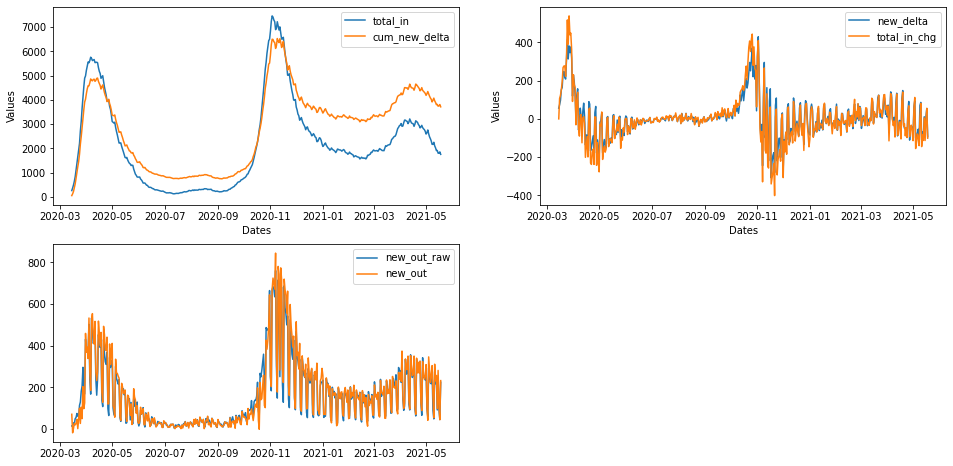

In [ ]:
#Horpitalizations data in Belgium
import copy
from datetime import datetime   # useful for date ranges in plots

sw_dataset = 'BEL'  # !! Default: 'BEL'. Currently 'BEL' and 'FRA' are available.
sw_districts = 'sum'  # !! Default: 'sum'. If 'sum', sums over all districts (i.e., provinces, departments...). If 'each', loop over all districts. sw_districts can also be the name of a district (for example, sw_districts = 'Brussels', or sw_districts = '75' for Paris, or sw_districts = 'London').  # PATODO fix London and stuff.
# ***********************************************************************************
# Load data Belgium
# *******   
# The data comes from https://epistat.sciensano.be/Data/COVID19BE_HOSP.csv.
# This link was provided on 22 June 2020 by Alexey Medvedev on the "Re R0 estimation" channel of the O365G-covidata team on MS-Teams.
# The link can be reached from https://epistat.wiv-isp.be/covid/
# Some explanations can be found at https://epistat.sciensano.be/COVID19BE_codebook.pdf
data_url='/COVID19BE_HOSP_2021-05-16.csv'
data_raw = pd.read_csv(data_url)  # !! changed:21PA
#fields = ['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']

if sw_districts == 'each':
    data_groupbydistrict = pd.DataFrame(data_raw.groupby("PROVINCE"))
if sw_districts == 'sum':
    nb_districts = 1
elif sw_districts == 'each':
    nb_districts = len(data_groupbydistrict)
else:  # else nb_districts is the name of a district
    nb_districts = 1
    
if nb_districts > 2:
    show_figures = 0  # Force figures off if there are too many districts

for cnt_district in range(nb_districts):

    if sw_districts == 'sum':
        district_name = 'sum'
        district_names = np.array(['sum'])   # without np.array, we get an error in district_names[medians_argsort]
    elif sw_districts == 'each':
        district_name = data_groupbydistrict[0][cnt_district]
        district_names = data_groupbydistrict[0]
    else:
        district_name = sw_districts
        district_names = np.array([sw_districts])

    # ***********************************************************************************
    # Process data Belgium
    # *******
    if sw_districts == 'sum':
        data_raw_district = data_raw.groupby('DATE', as_index=False).sum()  # sum over provinces
    elif sw_districts == 'each':
        data_raw_district = data_groupbydistrict[1][cnt_district]  # extract province cnt_district
    else:   
        data_raw_district = data_raw[data_raw.iloc[:,1]==sw_districts].reset_index(drop=True)   # extract district with name sw_districts

    data = data_raw_district[['DATE', 'NR_REPORTING', 'TOTAL_IN','TOTAL_IN_ICU','TOTAL_IN_RESP','TOTAL_IN_ECMO','NEW_IN','NEW_OUT']]  # exclude some useless columns
        
    # Extract relevant data and recompute new_out:
    # Source: Some variable names taken from https://rpubs.com/JMBodart/Covid19-hosp-be
    data_length = np.size(data,0)
    data_num = data.iloc[:,1:].to_numpy(dtype=float)  # extract all rows and 2nd--last columns (recall that Python uses 0-based indexing) and turn it into a numpy array of floats. The "float" type is crucial due to the use of np.nan below. (Setting an integer to np.nan does not do what it is should do.)

    #dates = data['DATE'])
    dates_raw = copy.deepcopy(data['DATE'])
    dates_raw = dates_raw.reset_index(drop=True)  # otherwise the index is not contiguous when sw_districts = 'each'
    Dates = [None] * data_length
    for i in range(0,data_length):
        Dates[i] = datetime.strptime(dates_raw[i],'%Y-%m-%d')

    col_total_in = 1
    col_new_in = 5
    col_new_out = 6
    total_in = data_num[:,col_total_in]
    new_in = data_num[:,col_new_in]
    new_out_raw = data_num[:,col_new_out] # there will be a non-raw due to the "Problem" mentioned below.
    new_delta = new_in - new_out_raw
    cum_new_delta = np.cumsum(new_delta)
    total_in_chg = np.hstack(([0],np.diff(total_in))) #difference between x[i+1]-x[i]
    # Problem: new_delta and total_in_chg are different, though they are sometimes close. 
    # Cum_new_delta does not go back to something close to zero, whereas it should. Hence I should not trust it.
    # I'm going to trust total_in and new_in. I deduce new_out_fixed by:
    new_out = new_in - total_in_chg   # fixed new_out
    data_totinout = np.c_[total_in,new_in,new_out]  # store total_in, new_in, and new_iout in an arraw with 3 columns

    # Show Belgian data in figures:
    plt.figure(figsize=(16,8))
    plt.subplot(2,2,1)
    plt.plot(Dates, total_in)
    plt.plot(Dates,cum_new_delta)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("total_in","cum_new_delta"))
    #plt.ylim([0,1000])

    plt.subplot(2,2,2)
    plt.plot(Dates,new_delta)
    plt.plot(Dates,total_in_chg)
    plt.xlabel("Dates")
    plt.ylabel("Values")
    plt.legend(("new_delta","total_in_chg"))

    plt.subplot(2,2,3)
    plt.plot(Dates,new_out_raw)
    plt.plot(Dates,new_out)
    plt.legend(("new_out_raw","new_out"))

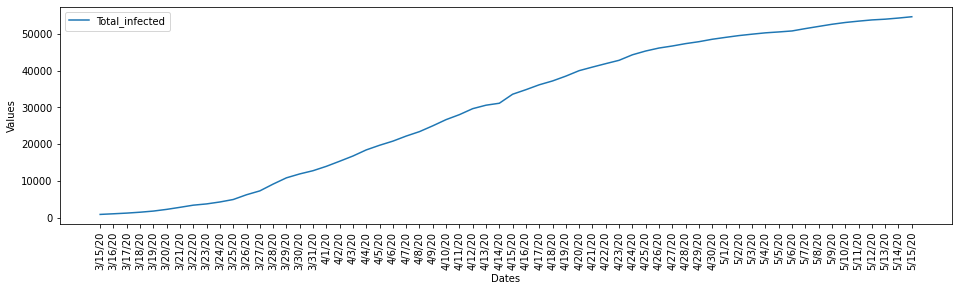

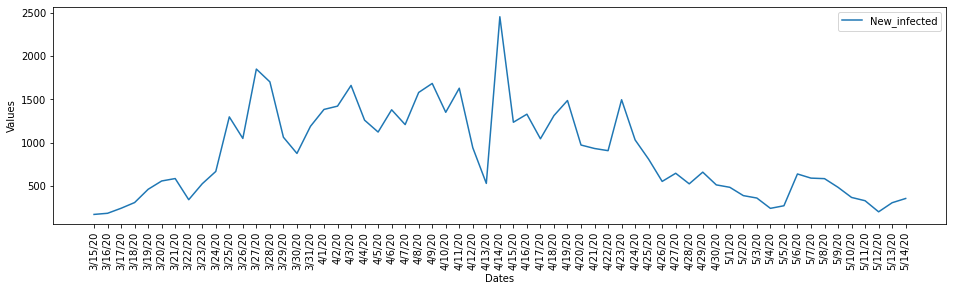

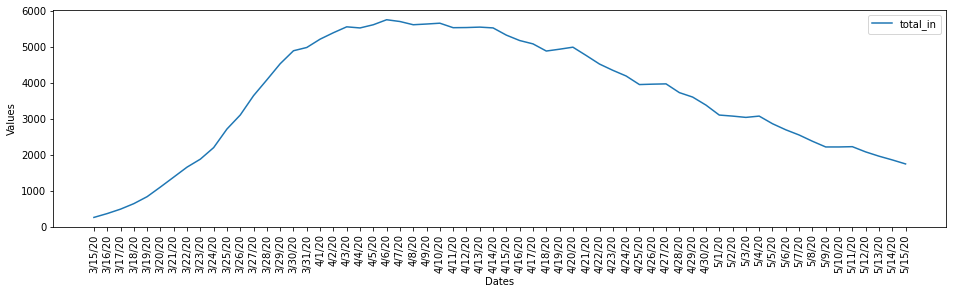

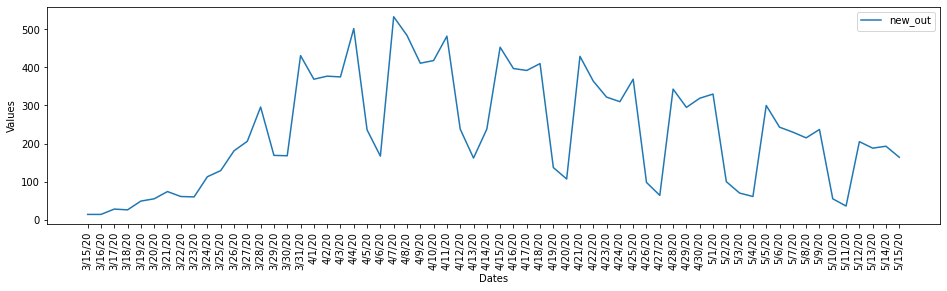

In [ ]:
hospi=data.TOTAL_IN[:62] #hospitalization cases between 2020/03/15 and 2020/05/15
plt.figure(figsize=(16,4))
plt.plot(dates, cases_obs, label="Total_infected")
plt.xticks(rotation='90')
plt.ylabel("Values")
plt.xlabel("Dates")
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.plot(dates[:len(np.diff(cases_obs))], np.diff(cases_obs), label="New_infected")
plt.xticks(rotation='90')
plt.ylabel("Values")
plt.xlabel("Dates")
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.plot(dates, hospi, label="total_in")
plt.xlabel("Dates")
plt.xticks(rotation='90')
plt.ylabel("Values")
plt.legend()
plt.show()

plt.figure(figsize=(16,4))
plt.plot(dates, new_out_raw[:62], label="new_out")
plt.xlabel("Dates")
plt.xticks(rotation='90')
plt.ylabel("Values")
plt.legend()
plt.show()

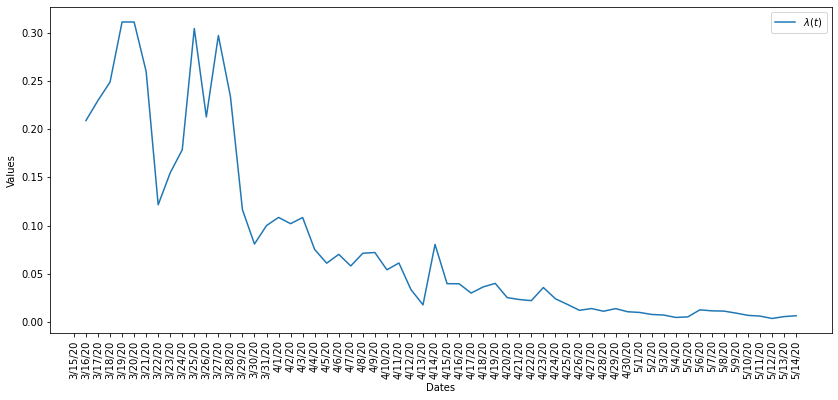

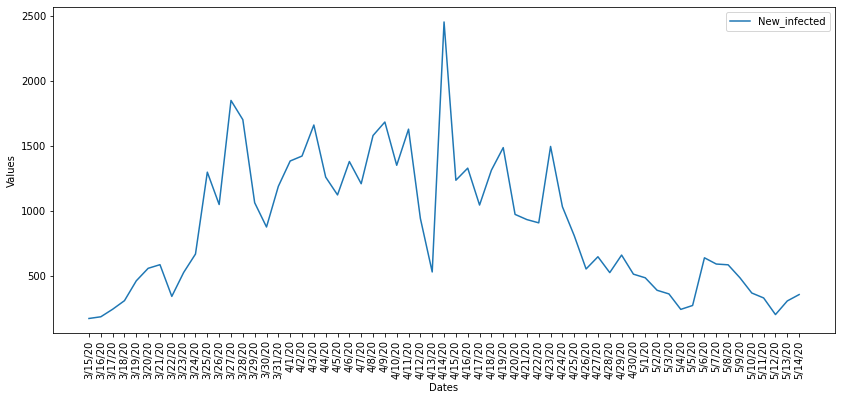

In [ ]:
#data_end   = '5/15/20' #Take the data until yesterday
#data_begin = '3/15/20'
#cases_obs = np.array(confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end])[0]
#dates=confirmed_cases.loc[confirmed_cases["Country/Region"] == "Belgium", data_begin:data_end].columns
data = pd.DataFrame({'Date':dates[:len(cases_obs)-1], 'Tot_inf':cases_obs[:len(cases_obs)-1], 'new_inf':np.diff(cases_obs), 'new_out': new_out_raw[:len(cases_obs)-1]})
#print(data)
lambda_by_day = np.full(np.shape(data)[0], np.nan)
for t in np.arange(1, np.shape(data)[0]):
    N=11.5e6
    S =np.full(np.shape(data)[0], np.nan)
    #I_total[0] = data.iloc[0,1]
    I_new = data.iloc[:,2]
    I_total = data.iloc[:,1]
    R_new = data.iloc[:,3]
    #S[0] = N - I_new[0] - R_new[0]
    S = N - np.cumsum(I_new) - np.cumsum(R_new)
    #print(S[t])
    lambda_by_day[t] = N*I_new[t] / (S[t-1]*I_total[t-1]) 
    #print(lambda_estimated[t])
plt.figure(figsize=(14,6))
plt.plot(dates[:len(cases_obs)-1], lambda_by_day, label='$\lambda(t)$')
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend()
plt.xticks(rotation='90')
plt.show()
plt.figure(figsize=(14,6))
plt.plot(dates[:len(cases_obs)-1], data.iloc[:,2], label='New_infected')
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend()
plt.xticks(rotation='90')
plt.show()


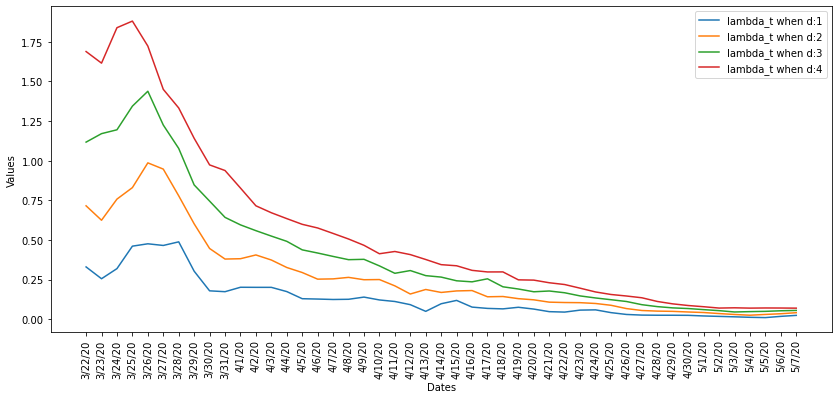

In [ ]:
plt.figure(figsize=(14,6))
t_i = 7
values = np.arange(t_i, np.shape(data)[0]-t_i)
lambda_estimated = np.full(np.shape(data)[0], np.nan)
for d in [1,2,3,4]:
    for t in values:
        N=11.5e6
        S =np.full(np.shape(data)[0], np.nan)
        I_total = data.iloc[t-d:t+d,1]
        R_new = data.iloc[t-d:t+d,3]
        I_new = data.iloc[t-d:t+d,2]
        S = N - np.cumsum(I_new) - np.cumsum(R_new)
        lambda_estimated[t] = N*np.sum(I_new) / (S[t-1]*I_total[t-1]) 
        #print(lambda_estimated[t])
    #print(lambda_estimated)
    plt.plot(dates[values], lambda_estimated[values], label='lambda_t when d:'+str(d))
plt.xlabel("Dates")
plt.ylabel("Values")
plt.legend()
plt.xticks(rotation='90')
plt.show()

change_location1: [7, 14, 21, 28, 35, 61]


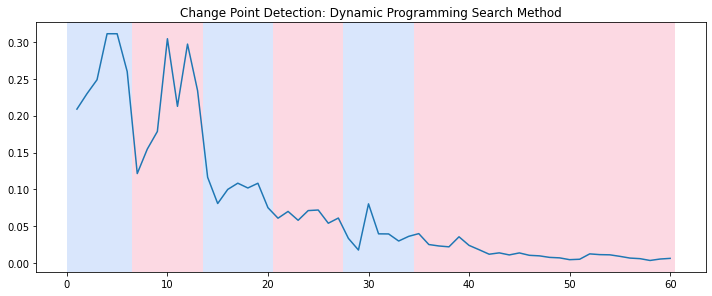

[       nan 0.20880699 0.22968633 0.2486063  0.31092854 0.31090412
 0.25968445 0.12152133 0.15470315 0.1785249  0.30417269 0.21258761
 0.29689804 0.23385108 0.11649239 0.08092952 0.10004208 0.10847952
 0.1019832  0.10839887 0.07526992 0.06104941 0.07022849 0.05821452
 0.07135888 0.07213985 0.0542244  0.06126295 0.03372444 0.01793374
 0.08048429 0.03985627 0.03972855 0.03013409 0.03647442 0.04015315
 0.02538119 0.02343484 0.02226771 0.03587461 0.02422651 0.01835223
 0.01226048 0.0140938  0.01130148 0.01401443 0.01077444 0.01004853
 0.00797579 0.00732951 0.0048753  0.00544046 0.01272049 0.01170284
 0.0114409  0.00937807 0.00703703 0.00625295 0.00380133 0.00574203
 0.00663388]


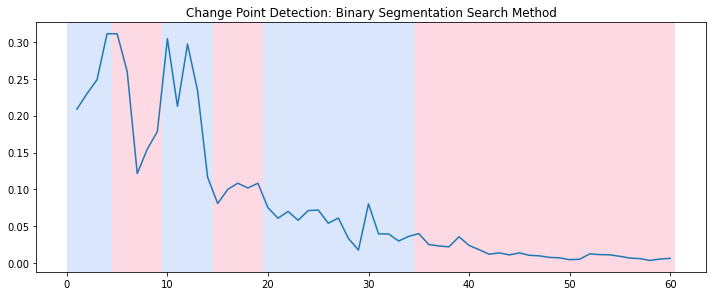

In [ ]:
#!pip install ruptures
import ruptures as rpt

#Convert the time series values to a numpy 1D array
points=np.array(lambda_by_day)

#Changepoint detection with dynamic programming search method
#Given a segment model, it computes the best partition for which the sum of errors is minimum.
model = "rbf"  #["l1", "l2", "rbf"]
algo = rpt.Dynp(model=model, min_size=3, jump=7).fit(points)
my_bkps = algo.predict(n_bkps=5)
print("change_location1:", my_bkps)
rpt.show.display(points, my_bkps,  figsize=(10, 4))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()
del my_bkps[-1]
print(points)
points[my_bkps]


#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=5)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 4))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

change_location1: [5, 10, 15, 20, 25, 61]
Index(['3/20/20', '3/25/20', '3/30/20', '4/4/20', '4/9/20', '5/15/20'], dtype='object')


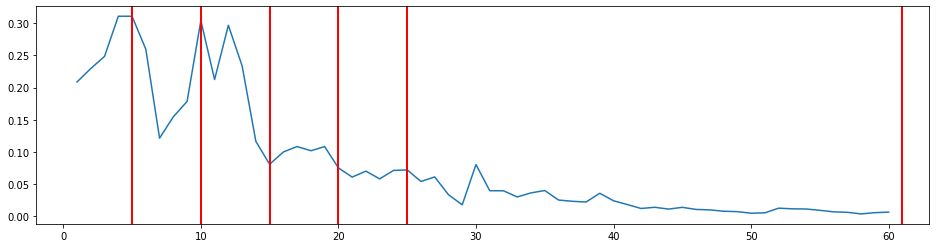

In [ ]:
# Detect the change points
algo1 = rpt.Dynp(model="l2", min_size=3, jump=5).fit(points) #min_size: minimum segment lenght; jump: subsample (one every *jump* points)
change_location1 = algo1.predict(n_bkps=5)    #n_bkps=10: is the number of breakpoints
print("change_location1:", change_location1)
# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(16,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')

plot_change_points(points,change_location1)
print(dates[change_location1])

In [ ]:
#*******************optional (if not cloned i.e. running in colab)
#!pip install covid19_inference
import datetime
import sys
import pymc as pm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 4, 21)
jhu = cov19.data_retrieval.JHU(auto_download=True)
cum_cases = jhu.get_total(country="Belgium", data_begin=bd, data_end=ed)
new_cases = jhu.get_new(country="Belgium", data_begin=bd, data_end=ed)

params_model = dict(
    new_cases_obs=new_cases,
    data_begin=bd,
    fcast_len=28,
    diff_data_sim=16,
    N_population=11.5e6,
)
# Median of the prior for the delay in case reporting, we assumed 8 days
pr_delay = 8
change_points = [
    # mild distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 9)
        # account for new implementation where transients_day is centered, not begin
        + datetime.timedelta(days=1.5),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=0.5,
    ),
    # strong distancing
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 16)
        + datetime.timedelta(days=1.5),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=0.5,
    ),
    # contact ban
    dict(
        pr_mean_date_transient=datetime.datetime(2020, 3, 23)
        + datetime.timedelta(days=1.5),
        pr_median_transient_len=3,
        pr_sigma_transient_len=0.3,
        pr_sigma_date_transient=1,
        pr_median_lambda=1 / 16,
        pr_sigma_lambda=0.5,
    ),
]

with cov19.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.35, #this value is obtained in the exponential phase fitting (unti 21/03/2020)
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,
        name_lambda_t="lambda_t",  # Name for the variable in the trace
    )
    # Adds the recovery rate mu to the model as a random variable
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)
    # This builds a decorrelated prior for I_begin for faster inference. It is not
    # necessary to use it, one can simply remove it and use the default argument for
    # pr_I_begin in cov19.model.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )
    # Use lambda_t_log and mu as parameters for the SIR model.
    # The SIR model generates the inferred new daily cases.
    new_cases = cov19.model.SIR(lambda_t_log=lambda_t_log, mu=mu, pr_I_begin=prior_I)

    # Delay the cases by a lognormal reporting delay and add them as a trace variable
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(cases=new_cases, name_cases="new_cases")

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(cases=new_cases)
idata = pm.sample(model=this_model, tune=500, draws=500, init="advi+adapt_diag")

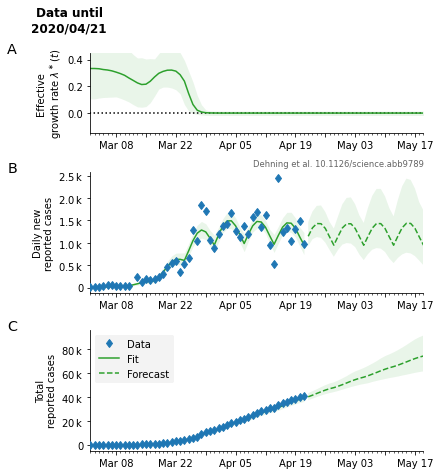

In [ ]:
fig, axes = cov19.plot.timeseries_overview(this_model, idata, offset=cum_cases[0])

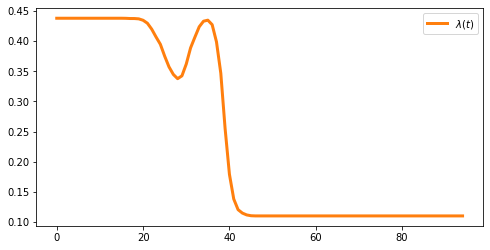

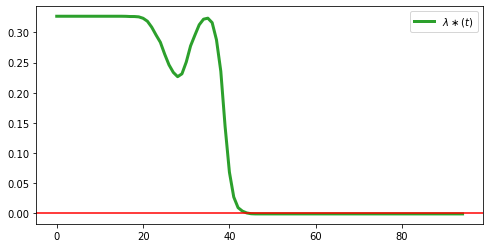

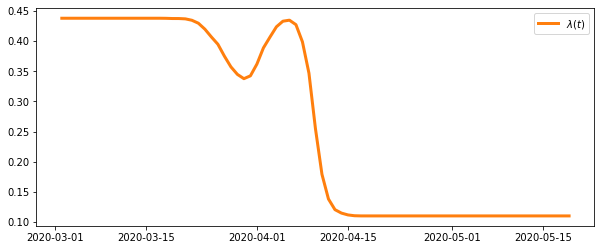

In [ ]:
bd = datetime.datetime(2020, 3, 2)
ed = datetime.datetime(2020, 5, 19)
jhu = cov19.data_retrieval.JHU(auto_download=True)
dates_data = jhu.get_new(country="Belgium", data_begin=bd, data_end=ed).index
plt.figure(figsize=(8,4))
plt.plot(np.median(idata.posterior.lambda_t, axis=1)[0], color='tab:orange', label='$\lambda (t)$', lw=3)
plt.legend()
plt.show()

np.median(idata.posterior.mu)
plt.figure(figsize=(8,4))
plt.plot(np.median(idata.posterior.lambda_t, axis=1)[0]-np.median(idata.posterior.mu), color='tab:green', label='$\lambda\\ast (t)$', lw=3)
plt.axhline(0.0, color= 'red')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(dates_data , np.median(idata.posterior.lambda_t, axis=1)[0][:len(dates_data)], color='tab:orange', label='$\lambda (t)$', lw=3)
plt.legend()
plt.show()

In [ ]:
#idata.get_index
#cov19.plot.get_array_from_idata_via_date(model, idata, 'lambda_t')


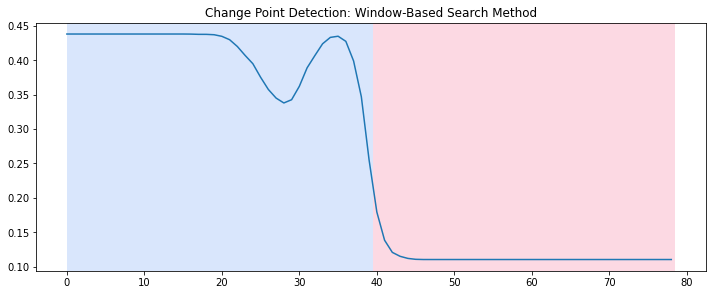

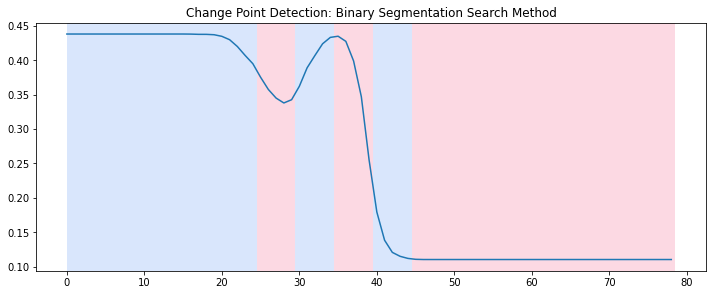

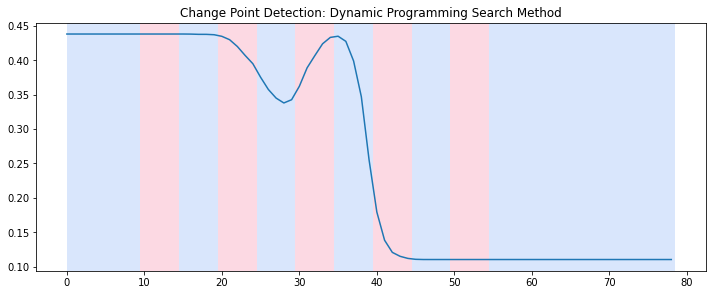

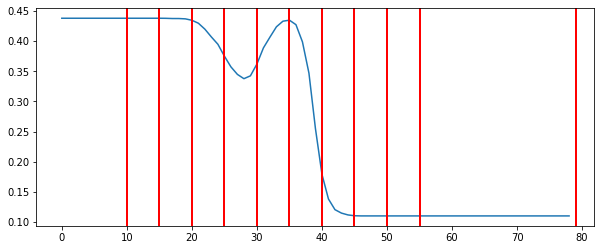

In [ ]:
#!pip install ruptures
import ruptures as rpt
points = np.array(np.median(idata.posterior.lambda_t, axis=1)[0][:len(dates_data)])

#Changepoint detection with window-based search method
model = "l2"  
algo = rpt.Window(width=40, model=model).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 4))
plt.title('Change Point Detection: Window-Based Search Method')
plt.show()

#Changepoint detection with the Binary Segmentation search method
model = "l2"  
algo = rpt.Binseg(model=model).fit(points)
my_bkps = algo.predict(n_bkps=5)
# show results
rpt.show.display(points, my_bkps, figsize=(10, 4))
plt.title('Change Point Detection: Binary Segmentation Search Method')
plt.show()

#Changepoint detection with dynamic programming search method
model = "l1"  
algo = rpt.Dynp(model=model, min_size=3, jump=5).fit(points)
my_bkps = algo.predict(n_bkps=10)
rpt.show.display(points, my_bkps, figsize=(10, 4))
plt.title('Change Point Detection: Dynamic Programming Search Method')
plt.show()

# Detect the change points
algo1 = rpt.Dynp(model="l1", min_size=3, jump=5).fit(points)
change_location1 = algo1.predict(n_bkps=10)    #n_bkps is the number of breakpoints
# Point the change points:
def plot_change_points(ts,ts_change_loc):
    plt.figure(figsize=(10,4))
    plt.plot(ts)
    for x in ts_change_loc:
        plt.axvline(x,lw=2, color='red')

plot_change_points(points,change_location1)

In [ ]:
#!pip install changefinder
import changefinder

def findChangePoints(ts, r, order, smooth):
    '''
       r: Discounting rate
       order: AR model order
       smooth: smoothing window size T
    '''
    cf = changefinder.ChangeFinder(r=r, order=order, smooth=smooth)
    ts_score = [cf.update(p) for p in ts]
    #plt.figure(figsize=(16,4))
    #plt.plot(ts)
    #plt.figure(figsize=(16,4))
    #plt.plot(ts_score, color='red')
    return(ts_score)
    
ts_score1 = findChangePoints(points, r = 0.01, order = 3, smooth = 3)

ts_change_loc1 = pd.Series(ts_score1).nlargest(30) #20
ts_change_loc1 = ts_change_loc1.index
print(ts_change_loc1)

Int64Index([31, 32, 21, 22, 30, 20, 23, 24, 19, 44, 43, 38, 37, 26, 33, 40, 41,
            39, 34, 27, 36, 42, 35, 45, 46, 47, 48, 49, 50, 51],
           dtype='int64')
